In [62]:
import os;
import sys;
import random;
import json

import numpy as np;
import cv2;
import matplotlib.pyplot as plt;

import tensorflow as tf
from tensorflow import keras;
import openslide
import imutils

import pylab




from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel;
import skimage
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float


import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

from skimage.filters.rank import entropy
from skimage.morphology import disk

from skimage.feature import local_binary_pattern




from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel;
import skimage
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float


import cv2;

import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color


from skimage.filters.rank import entropy
from skimage.morphology import disk



from skimage.filters import meijering,  frangi, hessian
from skimage.filters import meijering, sato

In [63]:
datapath="./gland/";

train_ids=[];
test_ids=[];
test_ids2=[];

files=os.listdir(datapath)
for i in files:
    i = i.replace("_anno.bmp","").replace(".bmp","");
    if i.startswith("testB"):
        test_ids2.append(i)
        
    elif i.startswith("train"):
        train_ids.append(i)
        
    elif i.startswith("testA"):
        test_ids.append(i)
        

train_ids=list(set(train_ids))
test_ids=list(set(test_ids))
test_ids2=list(set(test_ids2))


print(len(train_ids))
print(len(test_ids))
print(len(test_ids2))

85
60
20


In [64]:
class DataGen(keras.utils.Sequence):
    def __init__(self,ids,batch_size=0,image_size=(256,256),funct=""):
        self.ids=ids;
        
        self.batch_size =batch_size;
        self.image_size = image_size;
        self.funct = funct;
        
    def __load__(self,id_name):
        
        path=datapath;
        
        image_path = os.path.join(path,id_name)+".bmp";
        
        image = cv2.imread(image_path);
        
        mask_path= os.path.join(path,id_name)+"_anno.bmp";
        mask = cv2.imread(mask_path,-1);
        
        thresh =0.5
        mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
        
        image =  cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
        
        
        
        image = cv2.resize(image,self.image_size);
        
        mask=cv2.resize(mask,self.image_size);
        mask = np.expand_dims(mask,axis=-1);
        mask =np.maximum(mask,mask);
        
        
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY);
        image2=image.copy();
        if self.funct=="":
            image =image/255.0;
            
        elif self.funct=="sobal":
            deep=cv2.CV_32F;
            x=cv2.Sobel(image2,deep,1,0)
            y=cv2.Sobel(image2,deep,0,1)

            absx= cv2.convertScaleAbs(x)
            absy= cv2.convertScaleAbs(y)

            dist = cv2.addWeighted(absx,0.5,absy,0.5,0)
            #dist_gray = cv2.cvtColor(dist, cv2.COLOR_RGB2GRAY);
            #image = dist_gray;
            
            image =image/255.0;
            
        elif self.funct=="lap":
            deep=cv2.CV_32F;
            lap = cv2.Laplacian(image2,deep,3)
            lap = cv2.convertScaleAbs(lap);
            #lap_gray = cv2.cvtColor(lap, cv2.COLOR_RGB2GRAY);
            #image=lap_gray;
            
            image =image/255.0;
            
        elif self.funct=="edge_roberts":
            image[:,:,0] = filters.roberts(image2[:,:,0])
            image[:,:,1] = filters.roberts(image2[:,:,1])
            image[:,:,2] = filters.roberts(image2[:,:,2])
            
        elif self.funct=="edge_sobel":
            image[:,:,0] = filters.sobel(image2[:,:,0])
            image[:,:,1] = filters.sobel(image2[:,:,1])
            image[:,:,2] = filters.sobel(image2[:,:,2])
            
        elif self.funct=="edge_scharr":
            
            image[:,:,0] = filters.scharr(image2[:,:,0])
            image[:,:,1] = filters.scharr(image2[:,:,1])
            image[:,:,2] = filters.scharr(image2[:,:,2])
            
        elif self.funct=="edge_prewitt":
            image[:,:,0] = filters.prewitt(image2[:,:,0])
            image[:,:,1] = filters.prewitt(image2[:,:,1])
            image[:,:,2] = filters.prewitt(image2[:,:,2])
        elif self.funct=="canny":
            canny1 = skimage.feature.canny(gray,sigma=1) 
            image[:,:,0]=canny1*1.0;
            canny2 = skimage.feature.canny(gray,sigma=3) 
            image[:,:,1]=canny2*1.0;
            
            canny3 = skimage.feature.canny(gray,sigma=5) 
            image[:,:,2]=canny3*1.0;
        
            
        elif self.funct=="entropy":
            res = entropy(gray, disk(2))
            res = res/np.max(res)
            image[:,:,0]=res
            res = entropy(gray, disk(5))
            res = res/np.max(res)
            image[:,:,1]=res
            
            res = entropy(gray, disk(10))
            res = res/np.max(res)
            image[:,:,2]=res
            
            
        
        elif self.funct=="lbp":
            radius = 8
            n_points = 20 * radius

            lbp1 = local_binary_pattern(gray, n_points, radius, "uniform")
            
            lbp1=lbp1/np.max(lbp1);
            
            radius = 3
            n_points = 8 * radius

            lbp2 = local_binary_pattern(gray, n_points, radius, "uniform")
            
            lbp2=lbp2/np.max(lbp2);
            
            
            radius = 10
            n_points = 25 * radius

            lbp3 = local_binary_pattern(gray, n_points, radius, "uniform")
            
            lbp3=lbp3/np.max(lbp3);
            
            image[:,:,0]=lbp1;
            image[:,:,1]=lbp2;
            image[:,:,2]=lbp3;
            
        
        elif self.funct=="coner":
            dst = cv2.cornerHarris(image[:,:,0],2,3,0.01)
            dst = cv2.dilate(dst,None)
            ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
            
            image[:,:,0]=dst/255.0;
            
            
            dst = cv2.cornerHarris(image[:,:,1],2,3,0.01)
            dst = cv2.dilate(dst,None)
            ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
            
            image[:,:,1]=dst/255.0;
            
            
            dst = cv2.cornerHarris(image[:,:,2],2,3,0.01)
            dst = cv2.dilate(dst,None)
            ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
            
            image[:,:,2]=dst/255.0;
            
        elif self.funct=="meijering":
            res = skimage.filters.meijering(image)
            
            image=res;
        elif self.funct=="frangi":
            res = skimage.filters.frangi(image)
            
            image=res;
        elif self.funct=="hessian":
            res = skimage.filters.hessian(image)
            
            image=res;
            
        elif self.funct=="sato":
            res = skimage.filters.sato(image)
            
            image=res;
        
        
        mask = mask/255.0;
        
        
        
        return image, mask;
    
    def __getitem__(self,index):
        if (index+1)*self.batch_size >len(self.ids):
            self.bach_size=len(self.ids)-index*batch_size;
            
        files_batch = self.ids[index*self.batch_size:(index+1)*self.batch_size]
        
        image=[];
        mask=[];
        
        for id_name in files_batch:
            _img,_mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask);
        
        image =np.array(image)
        mask =np.array(mask);
        
        return image, mask;
    
    def on_epoch_end(self):
        pass;
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));

In [65]:
image_size = (256,256);
batch_size = 10

In [66]:
test_data = DataGen(test_ids,batch_size=batch_size,image_size = image_size,funct="meijering")
test_data2 = DataGen(test_ids2,batch_size=batch_size,image_size = image_size,funct="meijering")

(10, 256, 256, 3) (10, 256, 256, 1)


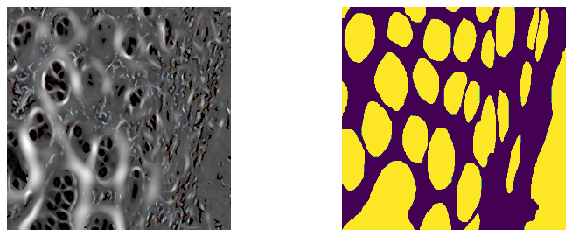

In [67]:

x,y = test_data.__getitem__(0)

print(x.shape,y.shape)

r=random.randint(0,len(x)-1);

fig = plt.figure(figsize=(10,10));
fig.subplots_adjust(hspace=0.5,wspace=0.5)
ax = fig.add_subplot(1,2,1)
ax.axis("off")
ax.imshow(x[r][:,:])
ax = fig.add_subplot(1,2,2)
ax.axis("off")
ax.imshow(np.reshape(y[r],image_size))



In [68]:
def down_block(x,filters,kernel_size=(3,3),padding="same",strides=1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(x);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    p = keras.layers.MaxPool2D((2,2),(2,2))(c);
    
    return c,p

def up_block(x,skip,filters,kernel_size=(3,3),padding="same",strides=1):
    us=keras.layers.UpSampling2D((2,2))(x);
    concat = keras.layers.Concatenate()([us,skip])
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(concat);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    return c;


def bottleneck(x,filters,kernel_size=(3,3),padding="same",strides=1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(x);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    return c;

In [69]:
def UNet():
    f = [16,32,64,128,256,512];
    
    inputs = keras.layers.Input(image_size+(3,))
    
    p0=inputs;
    c1,p1 = down_block(p0,f[0])  
    c2,p2 = down_block(p1,f[1]) 
    c3,p3 = down_block(p2,f[2])
    
    bn = bottleneck(p3,f[3])
    
    u3= up_block(bn,c3,f[2])
    u2= up_block(u3,c2,f[1])
    u1= up_block(u2,c1,f[0])
    
    outputs = keras.layers.Conv2D(1,(1,1),padding="same",activation='sigmoid')(u1);
    model = keras.models.Model(inputs,outputs)
    
    return model

In [70]:

smooth=1
def dice_coef(y_true,y_pred):
    
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f* y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+ smooth )
    
def dice_coef_loss(y_true,y_pred):
    return 1.0- dice_coef(y_true,y_pred)

In [71]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [72]:
functs=["sobal","lap","edge_roberts","edge_sobel","edge_scharr","edge_prewitt","canny","entropy","lbp","coner","meijering","frangi","hessian","sato"];

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [74]:
results=[];

In [ ]:

for funct in functs:
    
    valids= random.sample(train_ids,15);
    traids= [x for x in train_ids if x not in valids];
    train_data = DataGen(traids,batch_size=batch_size,image_size = image_size,funct=funct)
    valid_data = DataGen(valids,batch_size=batch_size,image_size = image_size,funct=funct)
    
    train_steps= len(traids)//batch_size;
    valid_steps= len(valids)//batch_size;
    
    epochs = 50;
    
    model = UNet();
    model.compile(optimizer = "adam",loss="binary_crossentropy",metrics=['acc',f1_m,precision_m, recall_m,dice_coef_loss]);
    checkpoint = ModelCheckpoint('model_test_'+funct+'_check.hdf5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

    #model.load_weights("model_test_check.hdf5")
    result = model.fit_generator(train_data, validation_data=valid_data, 
                                 steps_per_epoch=train_steps, 
                                 validation_steps=valid_steps, 
                                 epochs=epochs,callbacks=[checkpoint]
                                )
    results.append(result)
    model.save("filter_test_"+funct+"_model.hdf5")

Epoch 1/50
6/7 [========================>.....] - ETA: 10s - loss: 0.6911 - acc: 0.5109 - f1_m: 3.2587e-04 - precision_m: 0.4176 - recall_m: 1.6303e-04 - dice_coef_loss: 0.5253
Epoch 00001: val_loss improved from inf to 0.70082, saving model to model_test_lap_check.hdf5
7/7 [==============================] - 72s 10s/step - loss: 0.6924 - acc: 0.5055 - f1_m: 2.7932e-04 - precision_m: 0.3580 - recall_m: 1.3974e-04 - dice_coef_loss: 0.5246 - val_loss: 0.7008 - val_acc: 0.4154 - val_f1_m: 2.1823e-04 - val_precision_m: 0.8777 - val_recall_m: 1.0913e-04 - val_dice_coef_loss: 0.4821
Epoch 2/50
6/7 [========================>.....] - ETA: 9s - loss: 0.6856 - acc: 0.5275 - f1_m: 0.0835 - precision_m: 0.7971 - recall_m: 0.0487 - dice_coef_loss: 0.5188     
Epoch 00002: val_loss improved from 0.70082 to 0.69085, saving model to model_test_lap_check.hdf5
7/7 [==============================] - 72s 10s/step - loss: 0.6858 - acc: 0.5374 - f1_m: 0.1408 - precision_m: 0.7828 - recall_m: 0.0948 - dice_co

In [33]:
history={}

for i in range(len(results)):
    history[functs[i]]=results[i].history

for i in history:
    for j in history[i]:
        history[i][j]=[float(x) for x in history[i][j]]

In [34]:
with open('testhistory.json', 'w') as outfile:
    json.dump(history, outfile)

In [37]:
result=dict();
for i in history:
    acc =history[i]["acc"]
    val_acc = history[i]["val_acc"]
    maxacc = np.max(acc)
    maxval_acc = np.max(val_acc)
    result[i]={"acc":maxacc,"val_acc":maxval_acc}

In [30]:
labels=list(result.keys())
acc=[];
val_acc=[]
for i in labels:
    acc.append(result[i]['acc'])
    val_acc.append(result[i]['val_acc'])

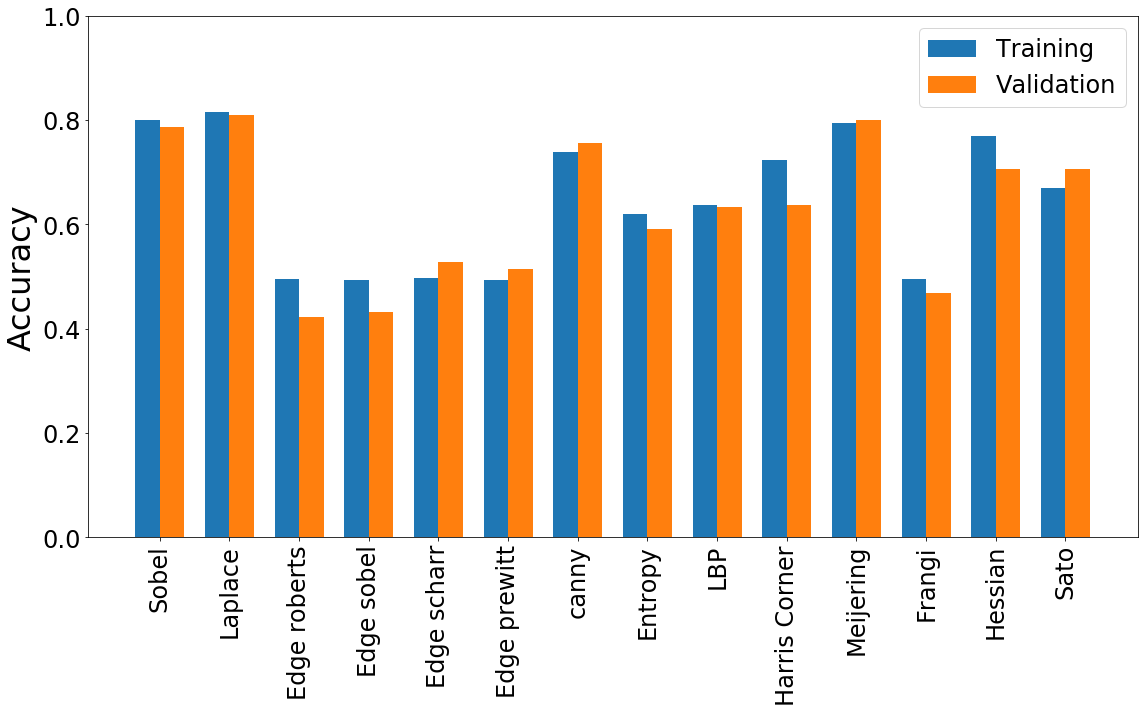

In [31]:
fig = plt.figure(figsize=(16,10));





x = np.arange(len(labels))  # the label locations
width = 0.35

ax = fig.add_subplot(1,1,1)



ax.set_ylim([0,1])
ax.set_ylabel('Accuracy', fontsize=32)
plt.xticks(fontsize=24 )
plt.yticks(fontsize=24 )

rects1 = ax.bar(x - width/2, acc, width, label='Training')
rects2 = ax.bar(x + width/2, val_acc, width, label='Validation')


ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90)

ax.legend(prop=dict(size=24))



fig.tight_layout()

In [110]:
table2 = "\n".join(table)
with open("screen_model.txt","w") as f:
    f.write(table2)